In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

%matplotlib inline


In [2]:
#Mendwonload fitur portion VGG19
vgg = models.vgg19(pretrained = True).features

#Bekukan semua VGG Parameter semenjak hanya mengoptimisasi target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
#Pindahkan model ke GPU jika ada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
def loadImage(imgPath, maxSize = 400, shape = None):
    #Load transform imaage, dan pastikan image lebih keci sama dengan 400 pixel
    
    image = Image.open(imgPath).convert('RGB')
    
    #Gambar yang besar akan memperlambat processing
    
    if max(image.size) > maxSize:
        size = maxSize
    else:
        size = max(image.size)
        
    if shape is not None:
        size  = shape
        
    inTransform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406 ),
                             (0.229, 0.224, 0.225))
    ])
    
    image = inTransform(image)[:3, :, :].unsqueeze(0)
    
    return image

In [5]:
content = loadImage('images/nopal.jpg').to(device)
style = loadImage('images/nomad_style.jpg', shape = content.shape[-2:]).to(device)

In [6]:
def imConvert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

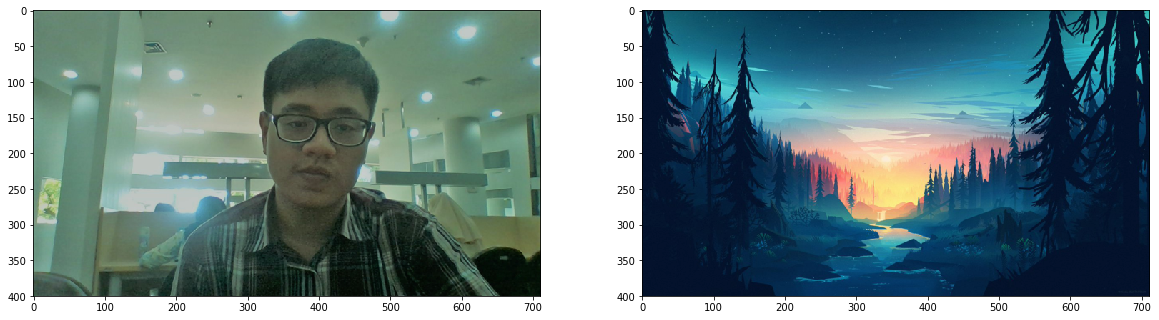

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(imConvert(content))
ax2.imshow(imConvert(style))

In [8]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [9]:
def getFeatures(image, model, layers = None):
    
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
  
    if layers is None:
        layers = {
            '0' : 'conv1_1',
            '5' : 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }
        
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features
            
            

In [10]:
def gramMatrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [11]:
contentFeatures = getFeatures(content, vgg)
styleFeatures = getFeatures(style, vgg)

styleGrams = {layer: gramMatrix(styleFeatures[layer]) for layer in styleFeatures}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [12]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
styleWeights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

contentWeight = 1  # alpha
styleWeight = 1e6  # beta

Total Loss : 16628275.0


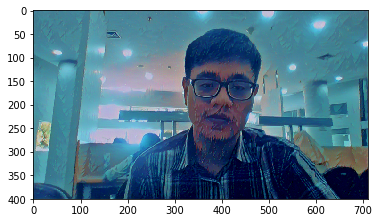

Total Loss : 7730919.5


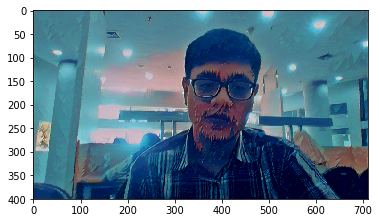

Total Loss : 4699958.5


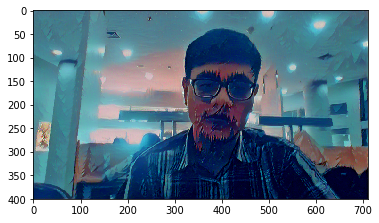

Total Loss : 3402546.75


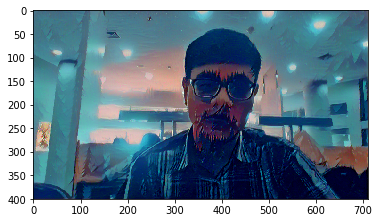

Total Loss : 2507036.0


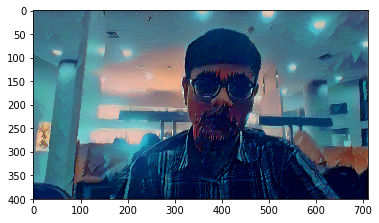

In [13]:
showEvery = 400

optimizer = optim.Adam([target], lr = 0.003)
steps = 2000

for ii in range(1, steps + 1):
    
    targetFeatures = getFeatures(target, vgg)
    
    contentLoss = torch.mean((targetFeatures['conv4_2'] - contentFeatures['conv4_2'])**2)
    
    styleLoss = 0
    
    for layer in styleWeights:
        
        targetFeature = targetFeatures[layer]
        targetGram = gramMatrix(targetFeature)
        _, d, h, w = targetFeature.shape
        styleGram = styleGrams[layer]
        layerStyleLoss = styleWeights[layer] * torch.mean((targetGram - styleGram)**2)
        styleLoss += layerStyleLoss / (d * h * w)
        
    totalLoss = contentWeight * contentLoss + styleWeight * styleLoss
    
    optimizer.zero_grad()
    totalLoss.backward()
    optimizer.step()
    
    if ii % showEvery == 0:
        print('Total Loss :', totalLoss.item())
        plt.imshow(imConvert(target))
        plt.show()
        

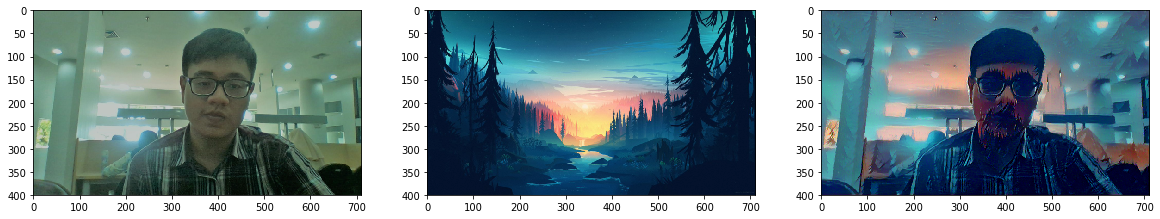

In [17]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(imConvert(content))
ax2.imshow(imConvert(style))
ax3.imshow(imConvert(target))